# Menu <a class="anchor" id="menu"></a>
* [1. Exploratory Data Analysis (EDA)](#eda)
* [2. Experimenting various models](#models)
    * [2.0 Preparing the dataset](#models_prepare)
    * [2.1 Establishing a baseline with DummyClassifier](#models_dummy)
    * [2.2 Logistic Regression](#models_linear)
    * [2.3 Decision Tree](#models_decision_tree)
    * [2.4 Random Forest](#models_random_forest)
    * [2.5 XGBoost](#models_xgboost)
* [3. Impoving the models with GreadSearchCV](#models_grid)
    * [3.1 Logistic Regression Grid](#models_linear_grid)
    * [3.2 Decision Tree Grid](#models_decision_tree_grid)
    * [3.3 Random Forest Grid](#models_random_forest_grid)
    * [3.4 XGBoost Grid](#models_xgboost_grid)
* [4. Impoving the models with solutions for Imbalanced datasets](#models_balanced)
    * [4.1 Balanced Logistic Regression Grid](#models_linear_balanced)
    * [4.2 Balanced Decision Tree Grid](#models_decision_tree_balanced)
    * [4.3 Balanced Random Forest Grid](#models_random_forest_balanced)
    * [4.4 Balanced XGBoost Grid](#models_xgboost_balanced)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

from zipfile import ZipFile

#### ---- Let's load the columns selected in the EDA ----

In [2]:
filename = 'data/dtypes_low.csv'

dtypes_df = pd.read_csv(filename, sep=',', index_col=0)

cols_to_keep = dtypes_df.columns
dtypes = dtypes_df.to_dict('records')[0]

#### \<test>

#### \<\test>

In [3]:
zip_file = ZipFile('data/Projet+Mise+en+prod+-+home-credit-default-risk.zip')

In [4]:
data_application_train = pd.read_csv(
    zip_file.open('application_train.csv'),
    #dtype=dtypes, 
    ######usecols=cols_to_keep,
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

pd.options.display.max_columns = data_application_train.shape[0]
pd.options.display.max_rows = 100

data_application_train.shape

(307511, 122)

#### \<test>

#### \<\test>

## Feature Engigeering

In [5]:
sample_size_base = 30000
sample_size_grid = 10000
data_clean = data_application_train[:sample_size_base].copy()

In [6]:
import missingno as msno

# Experimenting various models <a class="anchor" id="models"></a> [⇪](#menu)

## 0. Preparing the dataset <a class="anchor" id="models_prepare"></a> [⇪](#menu)

### Splitting the dataset between `train`, `validation` and `test` sets

- The `training set` is used to train various models.
- The `validation set` is used to select a model: we choose the one with the best performance on this set.
- The `test set` is used to estimate the generalization performance of the selected model.

Alternatively, instead of creating those three sets, we can separate the data into only two parts: a `training set` and a `test set` and then do a cross-validation on the `training set`. This allows us to choose a model (the one with the best performance), which we will then train on the whole `training set` and test on the `test set`. It is this final performance that is the best approximation of the performance that the model will be able to achieve on new data.

Let's first split the whole dataset in two `X(y)_train_full` and `X(y)_test`.<br>
Then let's split the `X(y)_train_full` into `X(y)_train` and `X(y)_valid`.

This gives us 4 sets; `X_train_full`, `X_train`, `X_valid`, `X_test` with which we can try various cross-validation methods.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_full = data_clean.copy()
X_full.drop(['TARGET'], axis=1, inplace=True)

Y_full = data_clean['TARGET']

In [9]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
                                                X_full, 
                                                Y_full, 
                                                test_size=0.20,
                                                random_state=0,
                                                stratify=Y_full)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(
                                                X_train_full, 
                                                y_train_full, 
                                                test_size=X_test.shape[0], 
                                                random_state=0,
                                                stratify=y_train_full)

In [11]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((18000, 121), (18000,), (6000, 121), (6000,), (6000, 121), (6000,))

### Encoding the qualitative variables

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

In [13]:
oe_targets = [x for x in X_train.select_dtypes(exclude='number').columns if X_train[x].nunique() == 2]
ohe_targets = [x for x in X_train.select_dtypes(exclude='number').columns if X_train[x].nunique() > 2]

In [14]:
def fit_labels(data):
    """ Prepare the encoder for the ordinal columns.
    - Columns with 2 unique values are encoded using an OrdinalEncoder
    - Columns with more than 2 unique values are encoded using a OneHotEncoder
        
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset used as reference for the label encoders
        
    Returns
    -------
    OrdinalEncoder
        the OE instance used to encode columns with 2 unique values
    OneHotEncoder
        the OHE instance used to encode columns with 3+ unique values
    """
    
    oe_targets = []
    ohe_targets = []
    
    for col in data.select_dtypes(exclude='number').columns:
        if data[col].nunique() == 2:
            oe_targets.append(col)
        else:
            ohe_targets.append(col)
        
    # OrdinalEncoder
    oe = OrdinalEncoder()
    oe.fit(data[oe_targets])
    
    # OneHotEncoder
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(data[ohe_targets])
    
    return oe, ohe

def transform_labels(data, oe_model, ohe_mode):
    """ Transform the provided dataset using the provided encoders.
            
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset that needs to be label encoded
        
    Returns
    -------
    DataFrame
        a new dataframe with the encoded labels instead of the non encoded ones
    """
    dt = data.copy()
    
    # OrdinalEncoder
    dt[oe_model.feature_names_in_] = oe_model.transform(dt[oe_model.feature_names_in_])
    
    # OneHotEncoder
    array_hot_encoded = ohe_model.transform(dt[ohe_model.feature_names_in_])
    data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dt.index, columns=ohe_model.get_feature_names_out())
    data_other_cols = dt.drop(columns=ohe_model.feature_names_in_)
    dt = pd.concat([data_hot_encoded, data_other_cols], axis=1)
    
    return dt

#### Fit the encoders

In [15]:
oe_model, ohe_model = fit_labels(X_train)

#### Transform the `training`, `validation` and `testing` sets

In [16]:
X_train = transform_labels(X_train, oe_model, ohe_model)
X_valid = transform_labels(X_valid, oe_model, ohe_model)
X_test = transform_labels(X_test, oe_model, ohe_model)
X_train_full = transform_labels(X_train_full, oe_model, ohe_model)

### Imputations

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [18]:
def fit_imputer(data, columns):
    
    imputer = SimpleImputer(strategy='median')
    #imputer = IterativeImputer(
    #    imputation_order='ascending', 
    #    random_state=0, 
        #min_value=0, 
        #max_value=max_values_imput
    #    n_nearest_features = 10,
    #)
    imputer.fit(data[columns])
    
    return imputer

def impute(data, imputer):
    
    dt = data.copy()
    dt_imput = pd.DataFrame(imputer.transform(dt[imputer.feature_names_in_]), index=dt.index, columns=imputer.feature_names_in_)
    dt[imputer.feature_names_in_] = dt_imput
    print(dt.shape, type(dt))
    
    return dt

In [19]:
imputer_model = fit_imputer(X_train, X_train.select_dtypes(include='number').columns)

In [20]:
X_train = impute(X_train, imputer_model)
X_valid = impute(X_valid, imputer_model)
X_test = impute(X_test, imputer_model)
X_train_full = impute(X_train_full, imputer_model)

(18000, 242) <class 'pandas.core.frame.DataFrame'>
(6000, 242) <class 'pandas.core.frame.DataFrame'>
(6000, 242) <class 'pandas.core.frame.DataFrame'>
(24000, 242) <class 'pandas.core.frame.DataFrame'>


<AxesSubplot:>

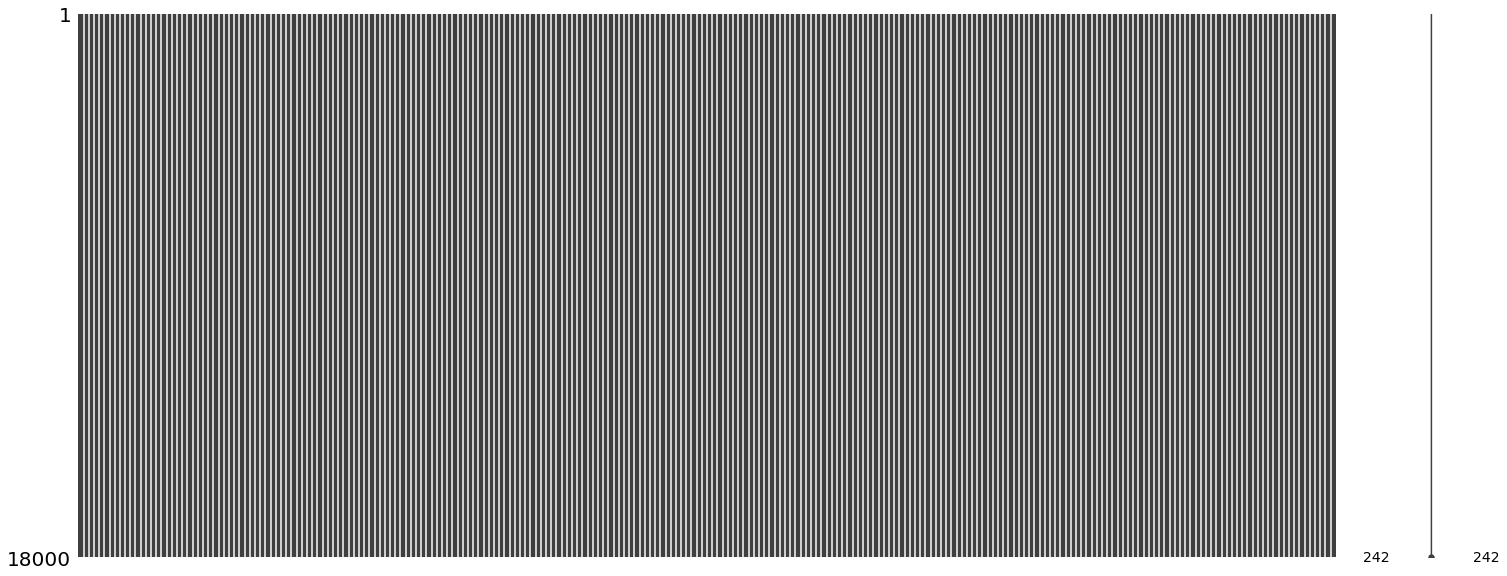

In [21]:
msno.matrix(X_train)

### Normalizing the dataset

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [23]:
def fit_normalizer(data):
    
    #minmax_scaler = MinMaxScaler(feature_range = (0, 1))
    #minmax_scaler.fit(data)
    
    #std_scaler = StandardScaler()
    #std_scaler.fit(data)
    
    #return minmax_scaler, std_scaler
    
    robust_scaler = RobustScaler()
    robust_scaler.fit(data)
    
    return robust_scaler

#def normalize(data, minmax_scaler, std_scaler):
def normalize(data, robust_scaler):
    
    dt = data.copy()
    #dt = pd.DataFrame(minmax_scaler.transform(dt), index=dt.index, columns=dt.columns)
    #dt = pd.DataFrame(std_scaler.transform(dt), index=dt.index, columns=dt.columns)
    dt = pd.DataFrame(robust_scaler.transform(dt), index=dt.index, columns=dt.columns)
    
    return dt

In [24]:
#normalizer_model, standardizer_model = fit_normalizer(X_train)
model_scaler = fit_normalizer(X_train)

In [25]:
#X_train = normalize(X_train, normalizer_model, standardizer_model)
#X_valid = normalize(X_valid, normalizer_model, standardizer_model)
#X_test = normalize(X_test, normalizer_model, standardizer_model)

X_train = normalize(X_train, model_scaler)
X_valid = normalize(X_valid, model_scaler)
X_test = normalize(X_test, model_scaler)
X_train_full = normalize(X_train_full, model_scaler)

### Define some report functions

In [26]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score

In [27]:
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, labels=[0,1], target_names=['Prediction = 0', 'Prediction = 1'], zero_division=0)
    print("--- Classification Report ---\n\n", report)

In [28]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    print("--- Confusion Matrix ---\n")
    plt.show()

In [29]:
def print_rocauc(y_true, y_pred_dict, figsize=[5,5], ax=None):
    
    print(f"--- ROC AUC ---\n")
    auc_scores = {}
    last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt

    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        alpha_v = 1 if i == last_index-1 else 0.5
        
        roc_score = roc_auc_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        
        ax.plot(fpr, tpr, label=f"{model_name} ({roc_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = roc_score
            
    ax.plot([0, 1], [0, 1], label='Random (0.5)', linestyle='--', color='red', alpha=0.5)
    plt.xlabel('FPR (Positive label: 1)')
    plt.ylabel('TPR (Positive label: 1)')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    return auc_scores

In [30]:
scores = pd.DataFrame(columns=['Method', 'ROC AUC', 'F1 score', 'Accuracy', 'Precision', 'Recall', 'TP', 'TN', 'FP', 'FN', 'Training time', 'Inference time'])
y_preds = {}
scores_path = 'data/scores.csv'
scores.to_csv(scores_path, index=False)

import time

def get_scores(method_name, model, X_ref=None, y_ref=None, threshold=None, training_time=None, inference_time=None, register=False, simple=False, show_classification=True, show_confusion=True, show_roccurves=True):
    
    if X_ref==None:
        X_ref = X_test
        
    if y_ref==None:
        y_ref = y_test
    
    y_pred, y_pred_proba, inference_time = predict(model, X_ref, threshold)
    
    rocauc_value = roc_auc_score(y_ref, y_pred_proba)
    f1_value = f1_score(y_ref, y_pred)
    accuracy_value = accuracy_score(y_ref, y_pred)
    precision_value = precision_score(y_ref, y_pred, zero_division=0)
    recall_value = recall_score(y_ref, y_pred)
    
    cm = confusion_matrix(y_ref, y_pred, labels=[0,1])
    TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    
    # Register score and replace if it already exists
    if register:
        idx = np.where(scores.Method == method_name)[0]        
        idx = idx[0] if idx.size > 0 else len(scores.index)
        scores.loc[idx] = [method_name, rocauc_value, f1_value, accuracy_value, precision_value, recall_value, TP, TN, FP, FN, training_time, inference_time]
        
        scores.to_csv(scores_path, index=False)
    
    # Basic report
    print(f"--- {method_name} ---\n\nROC AUC:{rocauc_value}\nF1-score:{f1_value}\nRecall:{recall_value}\n")
    
    if simple:
        return
    
    # Classification report
    if show_classification:
        print_classification_report(y_ref, y_pred)
    
    # Confusion Matrix
    if show_confusion:
        print_confusion_matrix(y_ref, y_pred)
    
    # ROC AUC curves
    if show_roccurves:
        y_preds[method_name] = y_pred_proba
        print_rocauc(y_ref, y_preds)

In [31]:
def get_labels_from_threshold(y_proba, threshold):
    return (y_proba >= threshold).astype('int')

def find_best_threshold(model, X_valid, y_valid, eval_function ):

    best_threshold = 0.0
    best_score = 0.0
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    
    for threshold in np.arange(0, 1, 0.001):
        
        y_pred_threshold = get_labels_from_threshold(y_pred_proba, threshold)
        
        score = eval_function(y_valid, y_pred_threshold)
        if score >= best_threshold:
            best_threshold = threshold
            best_score = score
        
    return best_score, best_threshold

In [32]:
def predict(model, X_ref, threshold=None):
    t0 = time.perf_counter()
    
    y_pred_proba = model.predict_proba(X_test)[:,1]
    if threshold:
        y_pred = get_labels_from_threshold(y_pred_proba, threshold)
    else:
        y_pred = model.predict(X_test)
    
    tt = time.perf_counter() - t0
    return y_pred, y_pred_proba, tt

In [327]:
def evaluate_model_CV(model, cv, X_ref, y_ref, scoring_method=None, scoring_args={}):

    model = cp.deepcopy(model)
    X_ref = X_ref.to_numpy()
    y_ref = y_ref.to_numpy()
    
    y_true = []
    y_pred_class = []
    y_pred_proba = []
    
    scores = []
    
    t0 = time.perf_counter()
    
    for i, (train_idx, test_idx) in enumerate(cv.split(X_ref, y_ref)):
        
        model.fit(X_ref[train_idx], y_ref[train_idx])
    
        y_true_fold = y_ref[test_idx]
        y_pred_class_fold = model.predict(X_ref[test_idx])
        y_pred_proba_fold = model.predict_proba(X_ref[test_idx])[:,1]
        
        y_true.extend(y_true_fold)
        y_pred_class.extend(y_pred_class_fold)
        y_pred_proba.extend(y_pred_proba_fold)
        
        if scoring_method:
        
            try:
                score = scoring_method(y_true_fold, y_pred_proba_fold, **scoring_args)
            except:
                score = scoring_method(y_true_fold, y_pred_class_fold, **scoring_args)
            
            print(f"{scoring_method.__name__.upper()} for fold-{i+1}: {score:.4f}")
            scores.append(score)
            
    total_time = time.perf_counter() - t0
    
    if scoring_method:
        
        try:
            overall_score = scoring_method(y_true, y_pred_proba, **scoring_args)
        except:
            overall_score = scoring_method(y_true, y_pred_class, **scoring_args)
        
        scores = pd.Series(scores)
        print(f"\nMEAN {scoring_method.__name__.upper()}: {scores.mean():.4f} with STD: {scores.std():.4f}")
        
        print(f"\nFULL-SET {scoring_method.__name__.upper()}: {overall_score:.4f}")
        
    return y_true, y_pred_class, y_pred_proba, total_time

## 1. Establishing baseline with Dummy Classifier <a class="anchor" id="models_dummy"></a> [⇪](#menu)

In [316]:
from sklearn.dummy import DummyClassifier

In [325]:
clf_dummy = DummyClassifier(strategy='stratified', random_state=0)
skfold = StratifiedKFold(n_splits=5)

In [328]:
y_true, y_pred_class, y_pred_proba, tt = evaluate_model_CV(clf_dummy, skfold, X_train_full, y_train_full, roc_auc_score)

ROC_AUC_SCORE for fold-1: 0.5093
ROC_AUC_SCORE for fold-2: 0.4854
ROC_AUC_SCORE for fold-3: 0.4852
ROC_AUC_SCORE for fold-4: 0.5056
ROC_AUC_SCORE for fold-5: 0.5022

MEAN ROC_AUC_SCORE: 0.4975 with STD: 0.0115

FULL-SET ROC_AUC_SCORE: 0.4975


--- Dummy ---

ROC AUC:0.49742149497539967
F1-score:0.07621009268795056
Recall:0.07692307692307693

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.92      0.92      5519
Prediction = 1       0.08      0.08      0.08       481

      accuracy                           0.85      6000
     macro avg       0.50      0.50      0.50      6000
  weighted avg       0.85      0.85      0.85      6000

--- Confusion Matrix ---



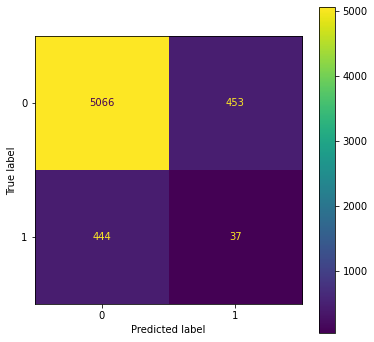

--- ROC AUC ---



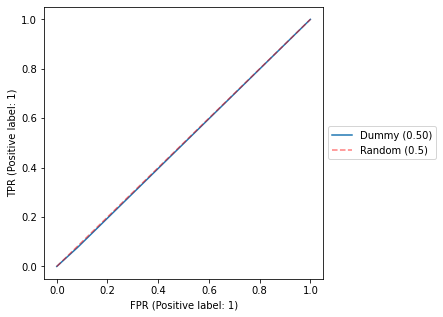

In [36]:
get_scores("Dummy", clf_dummy, training_time=tt, register=True)

> - The **recall** means "how many of this class you find over the whole number of element of this class"
> - The **precision** will be "how many are correctly classified among that class"
> - The **f1-score** is the harmonic mean between precision & recall
> - The **support** is the number of occurence of the given class in your dataset


## 2. Logistic Regression <a class="anchor" id="models_linear"></a> [⇪](#menu)

In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

In [169]:
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression

from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV

--- XXXX Logistic Regression ---

ROC AUC:0.6860013734447509
F1-score:0.0
Recall:0.0

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5519
Prediction = 1       0.00      0.00      0.00       481

      accuracy                           0.92      6000
     macro avg       0.46      0.50      0.48      6000
  weighted avg       0.85      0.92      0.88      6000

--- Confusion Matrix ---



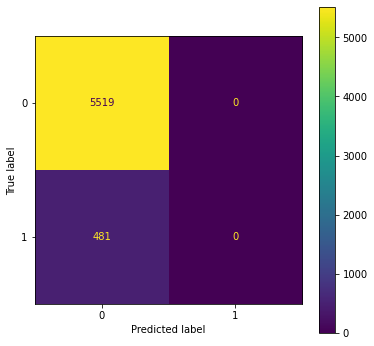

--- ROC AUC ---



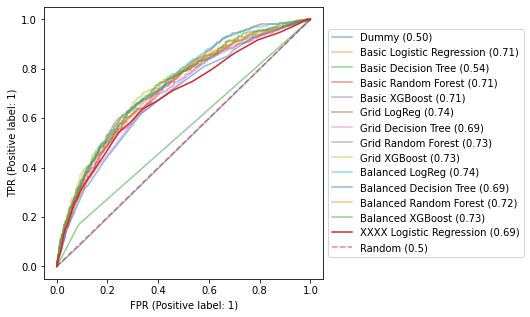

In [171]:
def train_model_CV(model, X_train, y_train, param_grid={}, scoring='accuracy', verbose=0, cv=None):
    
    if cv == None:
        cv = StratifiedKFold(n_splits=5, random_state=0)
        
    cv_model = HalvingGridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=verbose, cv=cv)
    cv_model.fit(X_train, y_train)
    
    return cv_model

    
x = train_model_CV(
    #LogisticRegression(C=0.1, random_state=0),
    RandomForestClassifier(random_state=0, n_jobs=-1),
    X_train_full, y_train_full,
    param_grid={},
    scoring='roc_auc',
    cv = StratifiedKFold(n_splits=3)
)

get_scores("XXXX Logistic Regression", x.best_estimator_, training_time=tt, register=False)

In [200]:
cv = StratifiedKFold(n_splits=5)
#cv_results = cross_val_score(clf_log, X_train_full, y_train_full, cv=cv, scoring='roc_auc')
cv_results = cross_validate(RandomForestClassifier(random_state=0, n_jobs=-1), X_train_full, y_train_full, cv=cv, scoring='roc_auc', return_estimator=True)
cv_results

{'fit_time': array([0.69597983, 0.62537098, 0.66602421, 0.62562609, 0.6394496 ]),
 'score_time': array([0.05914545, 0.05667257, 0.04648185, 0.03707576, 0.058146  ]),
 'estimator': [RandomForestClassifier(n_jobs=-1, random_state=0),
  RandomForestClassifier(n_jobs=-1, random_state=0),
  RandomForestClassifier(n_jobs=-1, random_state=0),
  RandomForestClassifier(n_jobs=-1, random_state=0),
  RandomForestClassifier(n_jobs=-1, random_state=0)],
 'test_score': array([0.68268032, 0.73806962, 0.71141304, 0.68298573, 0.64513417])}

In [201]:
print("%0.4f accuracy with a standard deviation of %0.4f" % (cv_results['test_score'].mean(), cv_results['test_score'].std()))

0.6921 accuracy with a standard deviation of 0.0312


In [313]:


xac, xpc, xpp = evaluate_model_CV(
    #LogisticRegression(C=0.1, random_state=0),
    RandomForestClassifier(random_state=0, n_jobs=-1),
    StratifiedKFold(n_splits=5),
    X_train_full, y_train_full,
    scoring_method=roc_auc_score
)

ROC_AUC_SCORE for fold-1: 0.6827
ROC_AUC_SCORE for fold-2: 0.7381
ROC_AUC_SCORE for fold-3: 0.7114
ROC_AUC_SCORE for fold-4: 0.6830
ROC_AUC_SCORE for fold-5: 0.6451

MEAN ROC_AUC_SCORE: 0.6921 with STD: 0.0349

FULL-SET ROC_AUC_SCORE: 0.6914


In [310]:
roc_auc_score(xac, xpp)

0.6914212149587181

In [39]:
clf_log = LogisticRegression(C=0.1, random_state=0)

In [40]:
t0 = time.perf_counter()

clf_log.fit(X_train, y_train)
##cv_results = cross_validate(clf_log, X_train_full, y_train_full, cv=3, scoring='roc_auc')

tt = time.perf_counter() - t0

/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Basic Logistic Regression ---

ROC AUC:0.7144410219242616
F1-score:0.008213552361396304
Recall:0.004158004158004158

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5519
Prediction = 1       0.33      0.00      0.01       481

      accuracy                           0.92      6000
     macro avg       0.63      0.50      0.48      6000
  weighted avg       0.87      0.92      0.88      6000

--- Confusion Matrix ---



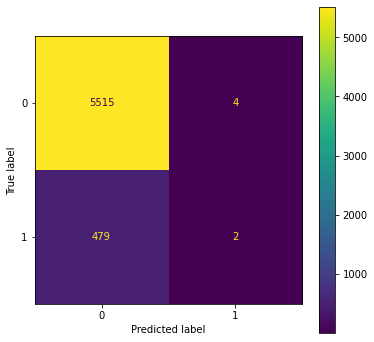

--- ROC AUC ---



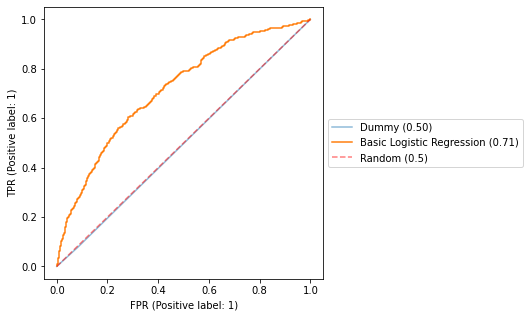

In [41]:
get_scores("Basic Logistic Regression", clf_log, training_time=tt, register=True)

#### Let's find the best threshold

In [42]:
f1_value, best_threshold = find_best_threshold(clf_log, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.22811671087533159) for this model is reached with a threshold of 0.23


--- Basic RegLog with 0.23 threshold ---

ROC AUC:0.7144410219242616
F1-score:0.23
Recall:0.19126819126819128

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.96      0.94      5519
Prediction = 1       0.29      0.19      0.23       481

      accuracy                           0.90      6000
     macro avg       0.61      0.58      0.59      6000
  weighted avg       0.88      0.90      0.89      6000

--- Confusion Matrix ---



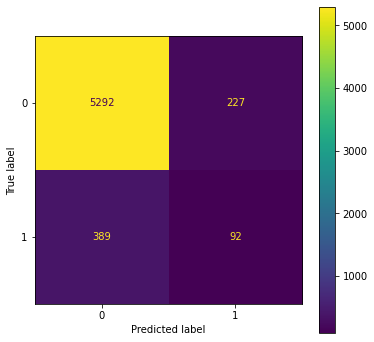

In [43]:
get_scores(f"Basic RegLog with {best_threshold} threshold", clf_log, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 3. Decision Tree <a class="anchor" id="models_decision_tree"></a> [⇪](#menu)

In [44]:
from sklearn.tree import DecisionTreeClassifier

In [45]:
clf_dt = DecisionTreeClassifier(random_state=0)

In [46]:
t0 = time.perf_counter()

clf_dt.fit(X_train, y_train)

tt = time.perf_counter() - t0

--- Basic Decision Tree ---

ROC AUC:0.5416623503233395
F1-score:0.157088122605364
Recall:0.1704781704781705

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.91      0.92      5519
Prediction = 1       0.15      0.17      0.16       481

      accuracy                           0.85      6000
     macro avg       0.54      0.54      0.54      6000
  weighted avg       0.86      0.85      0.86      6000

--- Confusion Matrix ---



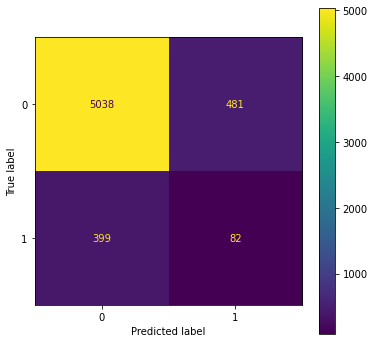

--- ROC AUC ---



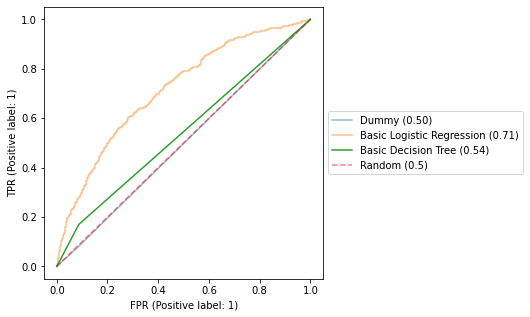

In [47]:
get_scores("Basic Decision Tree", clf_dt, training_time=tt, register=True)

#### Let's find the best threshold

In [48]:
f1_value, best_threshold = find_best_threshold(clf_dt, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.14133591481122942) for this model is reached with a threshold of 0.14200000000000002


--- Basic Decision Tree with 0.14200000000000002 threshold ---

ROC AUC:0.5416623503233395
F1-score:0.157088122605364
Recall:0.1704781704781705

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.91      0.92      5519
Prediction = 1       0.15      0.17      0.16       481

      accuracy                           0.85      6000
     macro avg       0.54      0.54      0.54      6000
  weighted avg       0.86      0.85      0.86      6000

--- Confusion Matrix ---



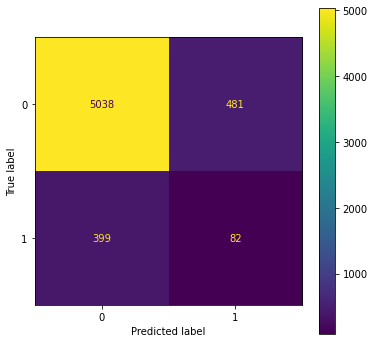

In [49]:
get_scores(f"Basic Decision Tree with {best_threshold} threshold", clf_dt, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 4. Random Forest <a class="anchor" id="models_random_forest"></a> [⇪](#menu)

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
clf_rf = RandomForestClassifier(random_state=0, n_jobs=-1, min_samples_split=100)

In [52]:
t0 = time.perf_counter()

clf_rf.fit(X_train, y_train)

tt = time.perf_counter() - t0

--- Basic Random Forest ---

ROC AUC:0.7092663070195232
F1-score:0.0
Recall:0.0

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5519
Prediction = 1       0.00      0.00      0.00       481

      accuracy                           0.92      6000
     macro avg       0.46      0.50      0.48      6000
  weighted avg       0.85      0.92      0.88      6000

--- Confusion Matrix ---



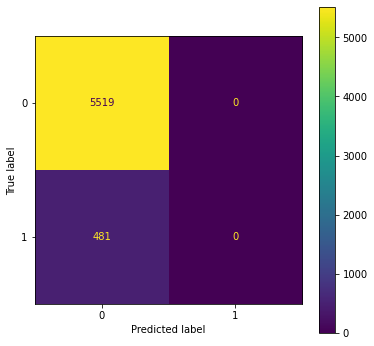

--- ROC AUC ---



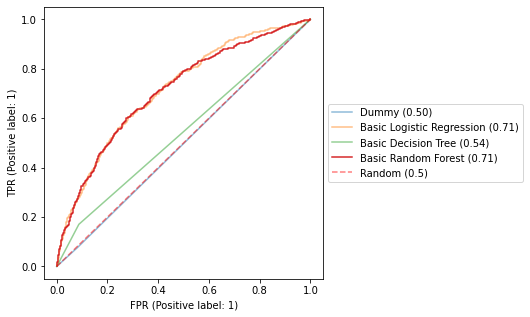

In [53]:
get_scores("Basic Random Forest", clf_rf, training_time=tt, register=True)

#### Let's find the best threshold

In [54]:
f1_value, best_threshold = find_best_threshold(clf_rf, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.20199146514935992) for this model is reached with a threshold of 0.202


--- Basic Random Forest with 0.202 threshold ---

ROC AUC:0.7092663070195232
F1-score:0.19142857142857145
Recall:0.1392931392931393

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.97      0.95      5519
Prediction = 1       0.31      0.14      0.19       481

      accuracy                           0.91      6000
     macro avg       0.62      0.56      0.57      6000
  weighted avg       0.88      0.91      0.89      6000

--- Confusion Matrix ---



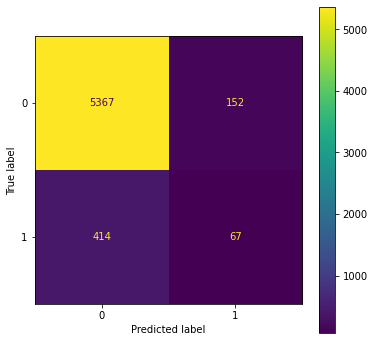

In [55]:
get_scores(f"Basic Random Forest with {best_threshold} threshold", clf_rf, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 5. XGBoost Classifier <a class="anchor" id="models_xgboost"></a> [⇪](#menu)

In [56]:
from xgboost import XGBClassifier

In [57]:
clf_xgb = XGBClassifier(
    # max_depth=6,
    # min_child_weight=1,
    objective='binary:logistic', # classification
    eval_metric='auc', # classification
    nthread=-1,
    seed=0,
    verbosity=1
)

In [58]:
t0 = time.perf_counter()

clf_xgb.fit(X_train, y_train)

tt = time.perf_counter() - t0

--- Basic XGBoost ---

ROC AUC:0.7057061242602103
F1-score:0.07692307692307693
Recall:0.04365904365904366

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      5519
Prediction = 1       0.32      0.04      0.08       481

      accuracy                           0.92      6000
     macro avg       0.62      0.52      0.52      6000
  weighted avg       0.87      0.92      0.89      6000

--- Confusion Matrix ---



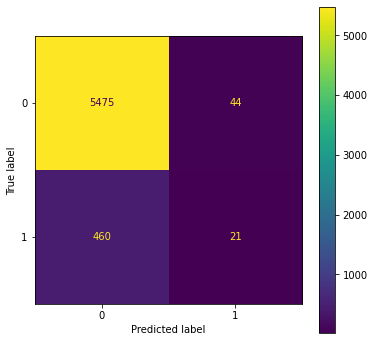

--- ROC AUC ---



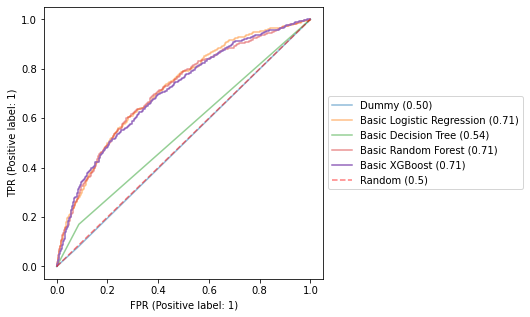

In [59]:
get_scores("Basic XGBoost", clf_xgb, training_time=tt, register=True)

#### Let's find the best threshold

In [60]:
f1_value, best_threshold = find_best_threshold(clf_xgb, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.23300970873786406) for this model is reached with a threshold of 0.23600000000000002


--- Basic XGBoost with 0.23600000000000002 threshold ---

ROC AUC:0.7057061242602103
F1-score:0.21575757575757576
Recall:0.18503118503118504

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.95      0.94      5519
Prediction = 1       0.26      0.19      0.22       481

      accuracy                           0.89      6000
     macro avg       0.59      0.57      0.58      6000
  weighted avg       0.88      0.89      0.88      6000

--- Confusion Matrix ---



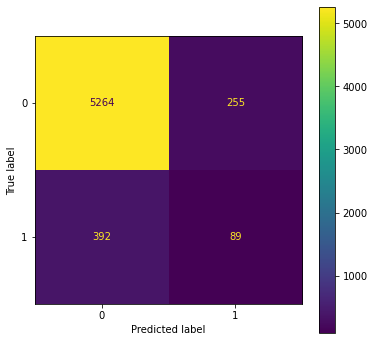

In [61]:
get_scores(f"Basic XGBoost with {best_threshold} threshold", clf_xgb, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 6. Review scores <a class="anchor" id="models_scores"></a> [⇪](#menu)

In [62]:
scores

,Method,ROC AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,Dummy,0.497421,0.076210,0.850500,0.075510,0.076923,37,5066,453,444,0.001175,0.002818
1,Basic Logistic Regression,0.714441,0.008214,0.919500,0.333333,0.004158,2,5515,4,479,1.692826,0.033768
2,Basic RegLog with 0.23 threshold,0.714441,0.230000,0.897333,0.288401,0.191268,92,5292,227,389,1.692826,0.007510
3,Basic Decision Tree,0.541662,0.157088,0.853333,0.145648,0.170478,82,5038,481,399,1.456932,0.013655
4,Basic Decision Tree with 0.14200000000000002 t...,0.541662,0.157088,0.853333,0.145648,0.170478,82,5038,481,399,1.456932,0.007307
5,Basic Random Forest,0.709266,0.000000,0.919833,0.000000,0.000000,0,5519,0,481,1.244758,0.125645
6,Basic Random Forest with 0.202 threshold,0.709266,0.191429,0.905667,0.305936,0.139293,67,5367,152,414,1.244758,0.082209
7,Basic XGBoost,0.705706,0.076923,0.916000,0.323077,0.043659,21,5475,44,460,6.779520,0.046251
8,Basic XGBoost with 0.23600000000000002 threshold,0.705706,0.215758,0.892167,0.258721,0.185031,89,5264,255,392,6.779520,0.024421


In [63]:
scores[['Method', 'ROC AUC', 'F1 score', 'Recall']]

,Method,ROC AUC,F1 score,Recall
0,Dummy,0.497421,0.076210,0.076923
1,Basic Logistic Regression,0.714441,0.008214,0.004158
2,Basic RegLog with 0.23 threshold,0.714441,0.230000,0.191268
3,Basic Decision Tree,0.541662,0.157088,0.170478
4,Basic Decision Tree with 0.14200000000000002 t...,0.541662,0.157088,0.170478
5,Basic Random Forest,0.709266,0.000000,0.000000
6,Basic Random Forest with 0.202 threshold,0.709266,0.191429,0.139293
7,Basic XGBoost,0.705706,0.076923,0.043659
8,Basic XGBoost with 0.23600000000000002 threshold,0.705706,0.215758,0.185031


# Improving the models with GridSearchCV <a class="anchor" id="models_grid"></a> [⇪](#menu)

In [64]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold

In [65]:
X_train_full = X_train_full[:sample_size_grid]
y_train_full = y_train_full[:sample_size_grid]

In [66]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

## 1. Logistic Regression Grid<a class="anchor" id="models_linear_grid"></a> [⇪](#menu)

In [67]:
param_grid = [
    {
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'solver' : ['saga'],
        'penalty' : ['l1', 'l2', 'elasticnet'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]


In [68]:
clf_log_model = LogisticRegression(max_iter=1000, random_state=0)
clf_log_grid = GridSearchCV(clf_log_model, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,

In [69]:
t0 = time.perf_counter()

#clf_log_grid.fit(X_train_full, y_train_full)
clf_log_grid.fit(X_train, y_train)

tt = time.perf_counter() - t0

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1471, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

 

In [70]:
clf_log_grid.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [71]:
get_scores("Grid LogReg", clf_log_grid, training_time=tt, register=False, simple=True)

--- Grid LogReg ---

ROC AUC:0.7351086155217339
F1-score:0.008213552361396304
Recall:0.004158004158004158



#### Let's find the best threshold

In [72]:
f1_value, best_threshold = find_best_threshold(clf_log_grid, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.225974025974026) for this model is reached with a threshold of 0.226


#### We train a new model using the best parameters

In [73]:
clf_log2 = LogisticRegression( **clf_log_grid.best_params_, random_state=0, max_iter=1000 )

In [74]:
t0 = time.perf_counter()

#clf_log2.fit(X_train_full, y_train_full)
clf_log2.fit(X_train, y_train)

tt = time.perf_counter() - t0

--- Grid LogReg ---

ROC AUC:0.7351086155217339
F1-score:0.008213552361396304
Recall:0.004158004158004158

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5519
Prediction = 1       0.33      0.00      0.01       481

      accuracy                           0.92      6000
     macro avg       0.63      0.50      0.48      6000
  weighted avg       0.87      0.92      0.88      6000

--- Confusion Matrix ---



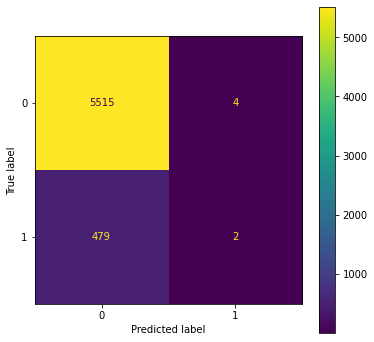

--- ROC AUC ---



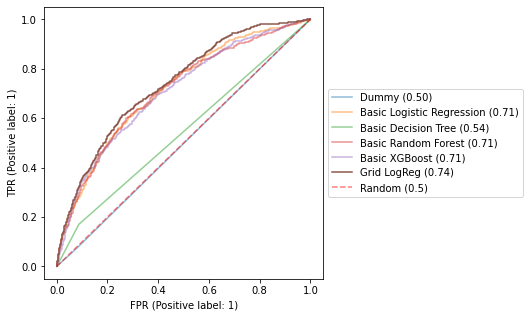

In [75]:
get_scores("Grid LogReg", clf_log2, training_time=tt, register=True)

#### Let's use the best threshold

--- Grid LogReg with 0.226 threshold ---

ROC AUC:0.7351086155217339
F1-score:0.22109275730622618
Recall:0.18087318087318088

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.96      0.95      5519
Prediction = 1       0.28      0.18      0.22       481

      accuracy                           0.90      6000
     macro avg       0.61      0.57      0.58      6000
  weighted avg       0.88      0.90      0.89      6000

--- Confusion Matrix ---



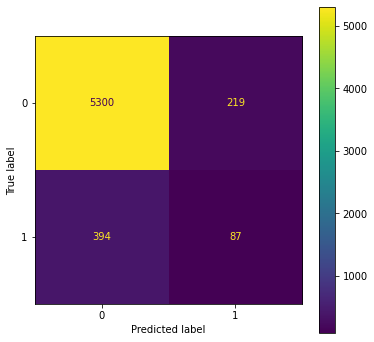

In [76]:
get_scores(f"Grid LogReg with {best_threshold} threshold", clf_log2, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 2. Decision Tree Grid <a class="anchor" id="models_decision_tree_grid"></a> [⇪](#menu)

In [77]:
param_grid = {
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    #'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
    'criterion' :['gini', 'entropy']
}

In [78]:
clf_dt_model = DecisionTreeClassifier(random_state=0)
clf_dt_grid = GridSearchCV(clf_dt_model, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,

In [79]:
t0 = time.perf_counter()

#clf_dt_grid.fit(X_train_full, y_train_full)
clf_dt_grid.fit(X_train, y_train)

tt = time.perf_counter() - t0

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


In [80]:
clf_dt_grid.best_params_

{'ccp_alpha': 0.001,
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': None}

In [81]:
get_scores("Grid Decision Tree", clf_dt_grid, training_time=tt, register=False, simple=True)

--- Grid Decision Tree ---

ROC AUC:0.6926111233956858
F1-score:0.0
Recall:0.0



#### Let's find the best threshold

In [82]:
f1_value, best_threshold = find_best_threshold(clf_dt_grid, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2410958904109589) for this model is reached with a threshold of 0.199


#### We train a new model using the best parameters

In [83]:
clf_dt2 = DecisionTreeClassifier( **clf_dt_grid.best_params_, random_state=0 )

In [84]:
t0 = time.perf_counter()

#clf_dt2.fit(X_train_full, y_train_full)
clf_dt2.fit(X_train, y_train)

tt = time.perf_counter() - t0

--- Grid Decision Tree ---

ROC AUC:0.6926111233956858
F1-score:0.0
Recall:0.0

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5519
Prediction = 1       0.00      0.00      0.00       481

      accuracy                           0.92      6000
     macro avg       0.46      0.50      0.48      6000
  weighted avg       0.85      0.92      0.88      6000

--- Confusion Matrix ---



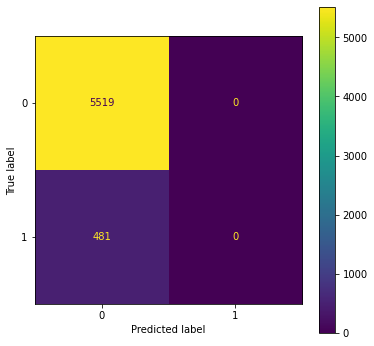

--- ROC AUC ---



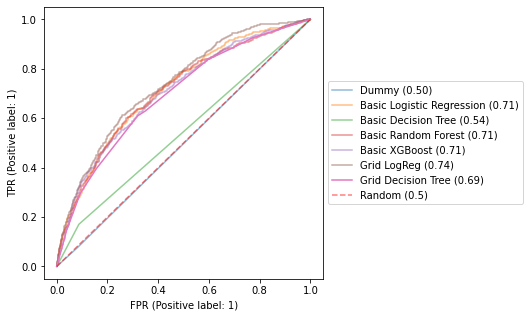

In [85]:
get_scores("Grid Decision Tree", clf_dt2, training_time=tt, register=True)

#### Let's use the best threshold

--- Grid Decision Tree with 0.199 threshold ---

ROC AUC:0.6926111233956858
F1-score:0.2510974539069359
Recall:0.2972972972972973

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.94      0.91      0.92      5519
Prediction = 1       0.22      0.30      0.25       481

      accuracy                           0.86      6000
     macro avg       0.58      0.60      0.59      6000
  weighted avg       0.88      0.86      0.87      6000

--- Confusion Matrix ---



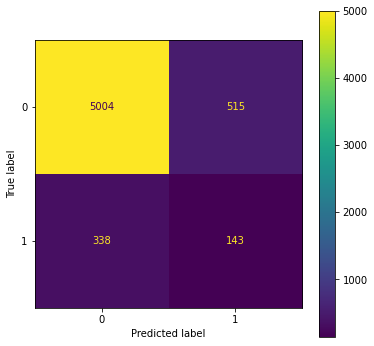

In [86]:
get_scores(f"Grid Decision Tree with {best_threshold} threshold", clf_dt2, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 3. Random Forest Grid <a class="anchor" id="models_random_forest_grid"></a> [⇪](#menu)

In [87]:
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    'n_estimators' :[64, 100, 128, 256, 528]
}

In [88]:
clf_rf_model = RandomForestClassifier(random_state=0)
clf_rf_grid = GridSearchCV(clf_rf_model, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,

In [89]:
t0 = time.perf_counter()

#clf_rf_grid.fit(X_train_full, y_train_full)
clf_rf_grid.fit(X_train, y_train)

tt = time.perf_counter() - t0

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


In [90]:
clf_rf_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 'auto',
 'n_estimators': 528}

In [91]:
get_scores("Grid Random Forest", clf_rf_grid, training_time=tt, register=False, simple=True)

--- Grid Random Forest ---

ROC AUC:0.7252986187575788
F1-score:0.0
Recall:0.0



#### Let's find the best threshold

In [92]:
f1_value, best_threshold = find_best_threshold(clf_rf_grid, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.1695447409733124) for this model is reached with a threshold of 0.168


#### We train a new model using the best parameters

In [93]:
clf_rf2 = RandomForestClassifier( **clf_rf_grid.best_params_, random_state=0 )

In [94]:
t0 = time.perf_counter()

#clf_rf2.fit(X_train_full, y_train_full)
clf_rf2.fit(X_train, y_train)

tt = time.perf_counter() - t0

--- Grid Random Forest ---

ROC AUC:0.7252986187575788
F1-score:0.0
Recall:0.0

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5519
Prediction = 1       0.00      0.00      0.00       481

      accuracy                           0.92      6000
     macro avg       0.46      0.50      0.48      6000
  weighted avg       0.85      0.92      0.88      6000

--- Confusion Matrix ---



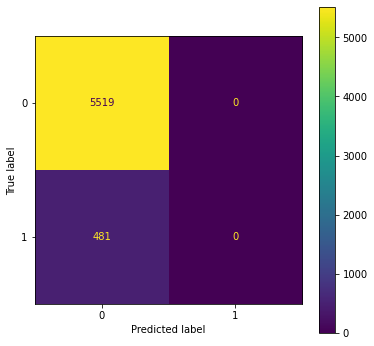

--- ROC AUC ---



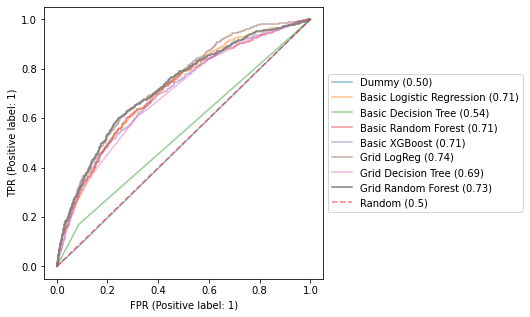

In [95]:
get_scores("Grid Random Forest", clf_rf2, training_time=tt, register=True)

#### Let's use the best threshold

--- Grid Random Forest with 0.168 threshold ---

ROC AUC:0.7252986187575788
F1-score:0.17080745341614906
Recall:0.11434511434511435

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.98      0.95      5519
Prediction = 1       0.34      0.11      0.17       481

      accuracy                           0.91      6000
     macro avg       0.63      0.55      0.56      6000
  weighted avg       0.88      0.91      0.89      6000

--- Confusion Matrix ---



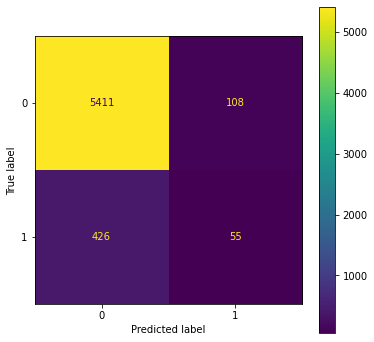

In [96]:
get_scores(f"Grid Random Forest with {best_threshold} threshold", clf_rf2, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 4. XGBoost Classifier Grid<a class="anchor" id="models_xgboost_grid"></a> [⇪](#menu)

In [97]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [98]:
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [99]:
clf_xgb_model = XGBClassifier(
    # max_depth=6,
    # min_child_weight=1,
    objective='binary:logistic', # classification
    eval_metric='auc', # classification
    nthread=-1,
    seed=0,
    verbosity=1
)
clf_xgb_grid = RandomizedSearchCV(clf_xgb_model, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,

In [100]:
t0 = time.perf_counter()

#clf_xgb_grid.fit(X_train_full, y_train_full)
clf_xgb_grid.fit(X_train, y_train)

tt = time.perf_counter() - t0

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [101]:
clf_xgb_grid.best_params_

{'n_estimators': 140, 'max_depth': 3, 'learning_rate': 0.1}

In [102]:
get_scores("Grid GXBoost", clf_xgb_grid, training_time=tt, register=False, simple=True)

--- Grid GXBoost ---

ROC AUC:0.7339604368051552
F1-score:0.012219959266802445
Recall:0.006237006237006237



#### Let's find the best threshold

In [103]:
f1_value, best_threshold = find_best_threshold(clf_xgb_grid, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.23624161073825503) for this model is reached with a threshold of 0.243


#### We train a new model using the best parameters

In [104]:
clf_xgb2 = XGBClassifier(
    # max_depth=6,
    # min_child_weight=1,
    objective='binary:logistic', # classification
    eval_metric='auc', # classification
    nthread=-1,
    seed=0,
    verbosity=1,
    **clf_xgb_grid.best_params_, 
)

In [105]:
t0 = time.perf_counter()

#clf_xgb2.fit(X_train_full, y_train_full)
clf_xgb2.fit(X_train, y_train)

tt = time.perf_counter() - t0

--- Grid XGBoost ---

ROC AUC:0.7339604368051552
F1-score:0.012219959266802445
Recall:0.006237006237006237

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5519
Prediction = 1       0.30      0.01      0.01       481

      accuracy                           0.92      6000
     macro avg       0.61      0.50      0.49      6000
  weighted avg       0.87      0.92      0.88      6000

--- Confusion Matrix ---



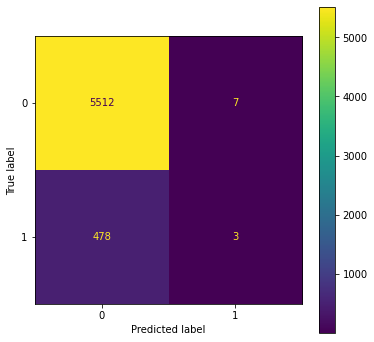

--- ROC AUC ---



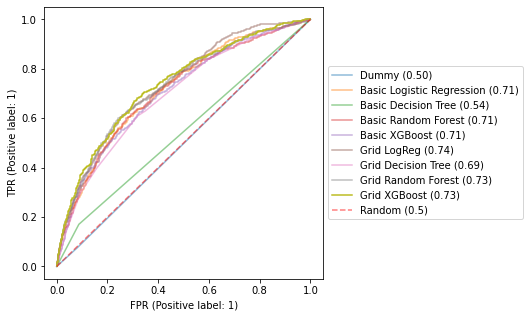

In [106]:
get_scores("Grid XGBoost", clf_xgb2, training_time=tt, register=True)

#### Let's use the best threshold

--- Grid XGBoost with 0.243 threshold ---

ROC AUC:0.7339604368051552
F1-score:0.22043010752688175
Recall:0.1704781704781705

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.97      0.95      5519
Prediction = 1       0.31      0.17      0.22       481

      accuracy                           0.90      6000
     macro avg       0.62      0.57      0.58      6000
  weighted avg       0.88      0.90      0.89      6000

--- Confusion Matrix ---



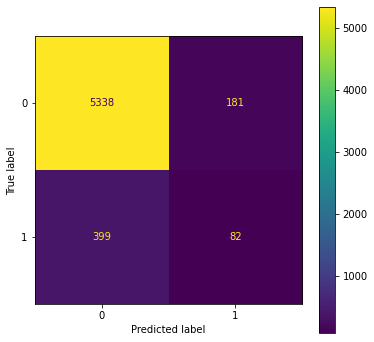

In [107]:
get_scores(f"Grid XGBoost with {best_threshold} threshold", clf_xgb2, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 5. Review scores <a class="anchor" id="models_grid_scores"></a> [⇪](#menu)

In [108]:
scores

,Method,ROC AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,Dummy,0.497421,0.076210,0.850500,0.075510,0.076923,37,5066,453,444,0.001175,0.002818
1,Basic Logistic Regression,0.714441,0.008214,0.919500,0.333333,0.004158,2,5515,4,479,1.692826,0.033768
2,Basic RegLog with 0.23 threshold,0.714441,0.230000,0.897333,0.288401,0.191268,92,5292,227,389,1.692826,0.007510
3,Basic Decision Tree,0.541662,0.157088,0.853333,0.145648,0.170478,82,5038,481,399,1.456932,0.013655
4,Basic Decision Tree with 0.14200000000000002 t...,0.541662,0.157088,0.853333,0.145648,0.170478,82,5038,481,399,1.456932,0.007307
5,Basic Random Forest,0.709266,0.000000,0.919833,0.000000,0.000000,0,5519,0,481,1.244758,0.125645
6,Basic Random Forest with 0.202 threshold,0.709266,0.191429,0.905667,0.305936,0.139293,67,5367,152,414,1.244758,0.082209
7,Basic XGBoost,0.705706,0.076923,0.916000,0.323077,0.043659,21,5475,44,460,6.779520,0.046251
8,Basic XGBoost with 0.23600000000000002 threshold,0.705706,0.215758,0.892167,0.258721,0.185031,89,5264,255,392,6.779520,0.024421
9,Grid LogReg,0.735109,0.008214,0.919500,0.333333,0.004158,2,5515,4,479,0.328640,0.011813


In [109]:
scores[['Method', 'ROC AUC', 'F1 score', 'Recall']].sort_values('Recall', ascending=False)

,Method,ROC AUC,F1 score,Recall
12,Grid Decision Tree with 0.199 threshold,0.692611,0.251097,0.297297
2,Basic RegLog with 0.23 threshold,0.714441,0.230000,0.191268
8,Basic XGBoost with 0.23600000000000002 threshold,0.705706,0.215758,0.185031
10,Grid LogReg with 0.226 threshold,0.735109,0.221093,0.180873
16,Grid XGBoost with 0.243 threshold,0.733960,0.220430,0.170478
4,Basic Decision Tree with 0.14200000000000002 t...,0.541662,0.157088,0.170478
3,Basic Decision Tree,0.541662,0.157088,0.170478
6,Basic Random Forest with 0.202 threshold,0.709266,0.191429,0.139293
14,Grid Random Forest with 0.168 threshold,0.725299,0.170807,0.114345
0,Dummy,0.497421,0.076210,0.076923


# Impoving the models with solutions for Imbalanced datasets <a class="anchor" id="models_balanced"></a> [⇪](#menu)

## 1. Balanced Logistic Regression Grid<a class="anchor" id="models_linear_balanced"></a> [⇪](#menu)

In [110]:
param_grid = [
    {
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'solver' : ['saga'],
        'penalty' : ['l1', 'l2', 'elasticnet'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [111]:
clf_log_model_imb = LogisticRegression(max_iter=1000, random_state=0, class_weight='balanced')
clf_log_imb = GridSearchCV(clf_log_model_imb, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,

In [112]:
t0 = time.perf_counter()

#clf_log_imb.fit(X_train_full, y_train_full)
clf_log_imb.fit(X_train, y_train)

tt = time.perf_counter() - t0

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1471, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

 

In [113]:
clf_log_imb.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [114]:
get_scores("Balanced LogReg", clf_log_imb, training_time=tt, register=False, simple=True)

--- Balanced LogReg ---

ROC AUC:0.7354841844785676
F1-score:0.24686520376175547
Recall:0.6548856548856549



#### Let's find the best threshold

In [115]:
f1_value, best_threshold = find_best_threshold(clf_log_imb, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2585307105580088) for this model is reached with a threshold of 0.5


#### We train a new model using the best parameters

In [116]:
clf_log_imb2 = LogisticRegression( **clf_log_imb.best_params_, max_iter=1000, random_state=0, class_weight='balanced')

In [117]:
t0 = time.perf_counter()

#clf_log_imb2.fit(X_train_full, y_train_full)
clf_log_imb2.fit(X_train, y_train)

tt = time.perf_counter() - t0

--- Balanced LogReg ---

ROC AUC:0.7354841844785676
F1-score:0.24686520376175547
Recall:0.6548856548856549

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.80      5519
Prediction = 1       0.15      0.65      0.25       481

      accuracy                           0.68      6000
     macro avg       0.55      0.67      0.52      6000
  weighted avg       0.89      0.68      0.75      6000

--- Confusion Matrix ---



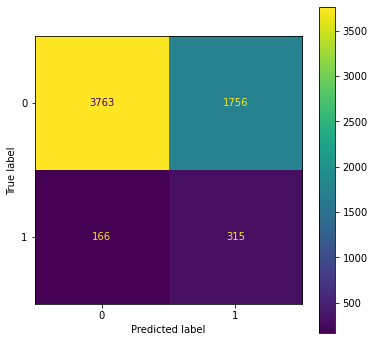

--- ROC AUC ---



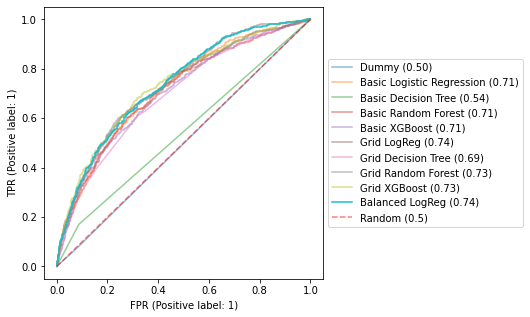

In [118]:
get_scores("Balanced LogReg", clf_log_imb2, training_time=tt, register=True)

#### Let's use the best threshold

--- Balanced LogReg with 0.5 threshold ---

ROC AUC:0.7354841844785676
F1-score:0.24686520376175547
Recall:0.6548856548856549

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.80      5519
Prediction = 1       0.15      0.65      0.25       481

      accuracy                           0.68      6000
     macro avg       0.55      0.67      0.52      6000
  weighted avg       0.89      0.68      0.75      6000

--- Confusion Matrix ---



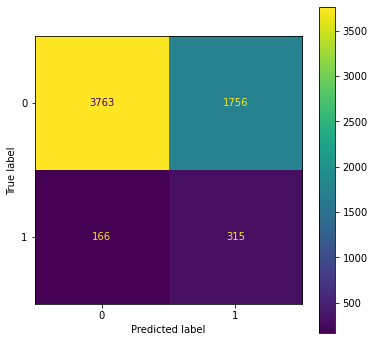

In [119]:
get_scores(f"Balanced LogReg with {best_threshold} threshold", clf_log_imb2, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 2. Balanced Decision Tree Grid <a class="anchor" id="models_decision_tree_balanced"></a> [⇪](#menu)

In [120]:
param_grid = {
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    #'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
    'criterion' :['gini', 'entropy']
}

In [121]:
clf_dt_model_imb = DecisionTreeClassifier(random_state=0, class_weight='balanced')
clf_dt_imb = GridSearchCV(clf_dt_model_imb, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,

In [122]:
t0 = time.perf_counter()

#clf_dt_imb.fit(X_train_full, y_train_full)
clf_dt_imb.fit(X_train, y_train)

tt = time.perf_counter() - t0

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


In [123]:
clf_dt_imb.best_params_

{'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 4, 'max_features': None}

In [124]:
get_scores("Balanced Decision Tree", clf_dt_imb, training_time=tt, register=False, simple=True)

--- Balanced Decision Tree ---

ROC AUC:0.6859162394585478
F1-score:0.22401762761659932
Recall:0.6340956340956341



#### Let's find the best threshold

In [125]:
f1_value, best_threshold = find_best_threshold(clf_dt_imb, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.25137278828553994) for this model is reached with a threshold of 0.5630000000000001


#### We train a new model using the best parameters

In [126]:
clf_dt_imb2 = DecisionTreeClassifier( **clf_dt_imb.best_params_, random_state=0, class_weight='balanced' )

In [127]:
t0 = time.perf_counter()

#clf_dt_imb2.fit(X_train_full, y_train_full)
clf_dt_imb2.fit(X_train, y_train)

tt = time.perf_counter() - t0

--- Balanced Decision Tree ---

ROC AUC:0.6859162394585478
F1-score:0.22401762761659932
Recall:0.6340956340956341

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.65      0.77      5519
Prediction = 1       0.14      0.63      0.22       481

      accuracy                           0.65      6000
     macro avg       0.54      0.64      0.50      6000
  weighted avg       0.89      0.65      0.73      6000

--- Confusion Matrix ---



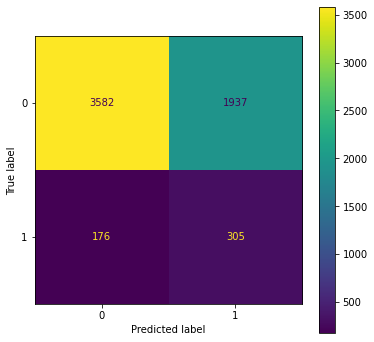

--- ROC AUC ---



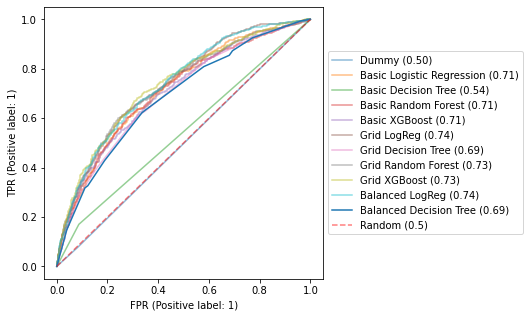

In [128]:
get_scores("Balanced Decision Tree", clf_dt_imb2, training_time=tt, register=True)

#### Let's use the best threshold

--- Balanced Decision Tree with 0.5630000000000001 threshold ---

ROC AUC:0.6859162394585478
F1-score:0.2385639837869137
Recall:0.4282744282744283

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.94      0.81      0.87      5519
Prediction = 1       0.17      0.43      0.24       481

      accuracy                           0.78      6000
     macro avg       0.55      0.62      0.56      6000
  weighted avg       0.88      0.78      0.82      6000

--- Confusion Matrix ---



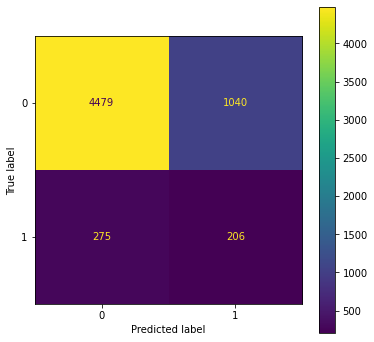

In [129]:
get_scores(f"Balanced Decision Tree with {best_threshold} threshold", clf_dt_imb2, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 3. Balanced Random Forest Grid <a class="anchor" id="models_random_forest_balanced"></a> [⇪](#menu)

In [130]:
param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    'n_estimators' :[64, 100, 128, 256, 528]
}

In [131]:
clf_rf_model_imb = RandomForestClassifier(random_state=0, class_weight='balanced')
clf_rf_imb = GridSearchCV(clf_rf_model_imb, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,

In [132]:
t0 = time.perf_counter()

#clf_rf_imb.fit(X_train_full, y_train_full)
clf_rf_imb.fit(X_train, y_train)

tt = time.perf_counter() - t0

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


In [133]:
clf_rf_imb.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'n_estimators': 528}

In [134]:
get_scores("Balanced Random Forest", clf_rf_imb, training_time=tt, register=False, simple=True)

--- Balanced Random Forest ---

ROC AUC:0.7224296787623476
F1-score:0.0
Recall:0.0



#### Let's find the best threshold

In [135]:
f1_value, best_threshold = find_best_threshold(clf_rf_imb, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2162162162162162) for this model is reached with a threshold of 0.215


#### We train a new model using the best parameters

In [136]:
clf_rf_imb2 = RandomForestClassifier( **clf_rf_imb.best_params_, random_state=0, class_weight='balanced')

In [137]:
t0 = time.perf_counter()

#clf_rf_imb2.fit(X_train_full, y_train_full)
clf_rf_imb2.fit(X_train, y_train)

tt = time.perf_counter() - t0

--- Balanced Random Forest ---

ROC AUC:0.7224296787623476
F1-score:0.0
Recall:0.0

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      5519
Prediction = 1       0.00      0.00      0.00       481

      accuracy                           0.92      6000
     macro avg       0.46      0.50      0.48      6000
  weighted avg       0.85      0.92      0.88      6000

--- Confusion Matrix ---



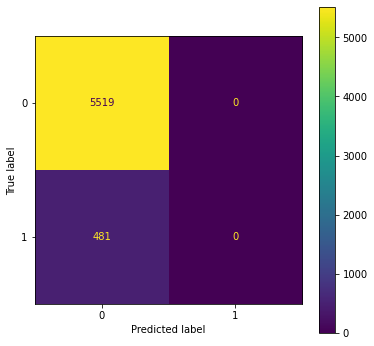

--- ROC AUC ---



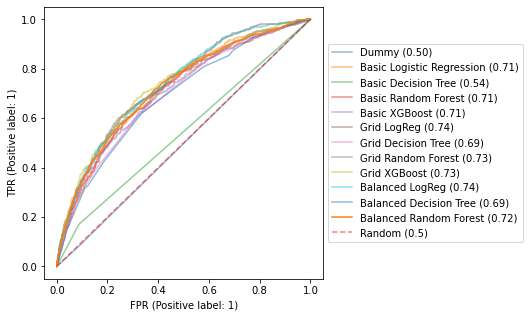

In [138]:
get_scores("Balanced Random Forest", clf_rf_imb2, training_time=tt, register=True)

#### Let's use the best threshold

--- Balanced Random Forest with 0.215 threshold ---

ROC AUC:0.7224296787623476
F1-score:0.1786743515850144
Recall:0.1288981288981289

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.97      0.95      5519
Prediction = 1       0.29      0.13      0.18       481

      accuracy                           0.91      6000
     macro avg       0.61      0.55      0.56      6000
  weighted avg       0.88      0.91      0.89      6000

--- Confusion Matrix ---



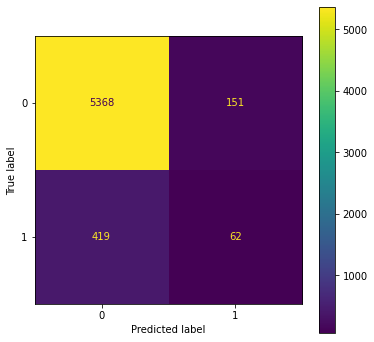

In [139]:
get_scores(f"Balanced Random Forest with {best_threshold} threshold", clf_rf_imb2, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 4. Balanced XGBoost Classifier Grid<a class="anchor" id="models_xgboost_balanced"></a> [⇪](#menu)

In [140]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

In [141]:
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [142]:
from collections import Counter

In [143]:
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]
scale_weigth

11.482662968099861

In [144]:
clf_xgb_model_imb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    nthread=8,
    seed=0,
    verbosity=1,
    scale_pos_weight=scale_weigth
)
clf_xgb_imb = RandomizedSearchCV(clf_xgb_model_imb, param_grid, scoring='roc_auc', n_jobs=-1, verbose=1, cv=cv) #cv=10,

In [145]:
t0 = time.perf_counter()

#clf_xgb_imb.fit(X_train_full, y_train_full)
clf_xgb_imb.fit(X_train, y_train)

tt = time.perf_counter() - t0

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [146]:
clf_xgb_imb.best_params_

{'n_estimators': 140, 'max_depth': 3, 'learning_rate': 0.05}

In [147]:
get_scores("Balanced XGBoost", clf_xgb_imb, training_time=tt, register=False, simple=True)

--- Balanced XGBoost ---

ROC AUC:0.7276285024065419
F1-score:0.2552490736928777
Recall:0.6444906444906445



#### Let's find the best threshold

In [148]:
f1_value, best_threshold = find_best_threshold(clf_xgb_imb, X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.27416356877323417) for this model is reached with a threshold of 0.523


#### We train a new model using the best parameters

In [149]:
clf_xgb_imb2 = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    nthread=-1,
    seed=0,
    verbosity=1,
    **clf_xgb_imb.best_params_, 
    random_state=0,
    scale_pos_weight=scale_weigth
)

In [150]:
t0 = time.perf_counter()

#clf_xgb_imb2.fit(X_train_full, y_train_full)
clf_xgb_imb2.fit(X_train, y_train)

tt = time.perf_counter() - t0

--- Balanced XGBoost ---

ROC AUC:0.7276285024065419
F1-score:0.2552490736928777
Recall:0.6444906444906445

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.70      0.81      5519
Prediction = 1       0.16      0.64      0.26       481

      accuracy                           0.70      6000
     macro avg       0.56      0.67      0.53      6000
  weighted avg       0.89      0.70      0.77      6000

--- Confusion Matrix ---



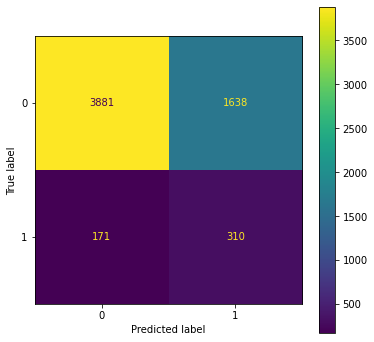

--- ROC AUC ---



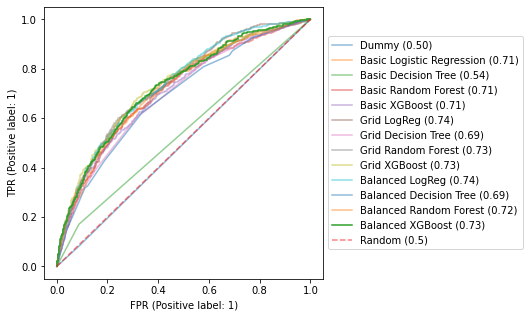

In [151]:
get_scores("Balanced XGBoost", clf_xgb_imb2, training_time=tt, register=True)

#### Let's use the best threshold

--- Balanced XGBoost with 0.523 threshold ---

ROC AUC:0.7276285024065419
F1-score:0.2583862194016319
Recall:0.5925155925155925

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.74      0.83      5519
Prediction = 1       0.17      0.59      0.26       481

      accuracy                           0.73      6000
     macro avg       0.56      0.67      0.55      6000
  weighted avg       0.89      0.73      0.79      6000

--- Confusion Matrix ---



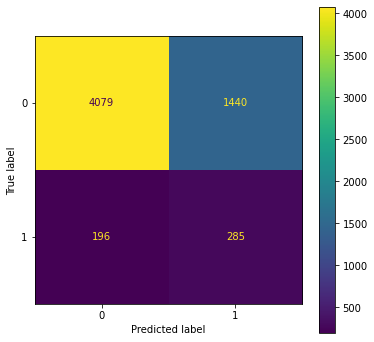

In [152]:
get_scores(f"Balanced XGBoost with {best_threshold} threshold", clf_xgb_imb2, threshold=best_threshold, training_time=tt, register=True, show_roccurves=False)

## 5. Review scores <a class="anchor" id="models_balanced_scores"></a> [⇪](#menu)

In [153]:
scores

,Method,ROC AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,Dummy,0.497421,0.076210,0.850500,0.075510,0.076923,37,5066,453,444,0.001175,0.002818
1,Basic Logistic Regression,0.714441,0.008214,0.919500,0.333333,0.004158,2,5515,4,479,1.692826,0.033768
2,Basic RegLog with 0.23 threshold,0.714441,0.230000,0.897333,0.288401,0.191268,92,5292,227,389,1.692826,0.007510
3,Basic Decision Tree,0.541662,0.157088,0.853333,0.145648,0.170478,82,5038,481,399,1.456932,0.013655
4,Basic Decision Tree with 0.14200000000000002 t...,0.541662,0.157088,0.853333,0.145648,0.170478,82,5038,481,399,1.456932,0.007307
5,Basic Random Forest,0.709266,0.000000,0.919833,0.000000,0.000000,0,5519,0,481,1.244758,0.125645
6,Basic Random Forest with 0.202 threshold,0.709266,0.191429,0.905667,0.305936,0.139293,67,5367,152,414,1.244758,0.082209
7,Basic XGBoost,0.705706,0.076923,0.916000,0.323077,0.043659,21,5475,44,460,6.779520,0.046251
8,Basic XGBoost with 0.23600000000000002 threshold,0.705706,0.215758,0.892167,0.258721,0.185031,89,5264,255,392,6.779520,0.024421
9,Grid LogReg,0.735109,0.008214,0.919500,0.333333,0.004158,2,5515,4,479,0.328640,0.011813


In [154]:
scores[['Method', 'ROC AUC', 'F1 score', 'Recall']].sort_values('ROC AUC', ascending=False)

,Method,ROC AUC,F1 score,Recall
17,Balanced LogReg,0.735484,0.246865,0.654886
18,Balanced LogReg with 0.5 threshold,0.735484,0.246865,0.654886
10,Grid LogReg with 0.226 threshold,0.735109,0.221093,0.180873
9,Grid LogReg,0.735109,0.008214,0.004158
15,Grid XGBoost,0.733960,0.012220,0.006237
16,Grid XGBoost with 0.243 threshold,0.733960,0.220430,0.170478
23,Balanced XGBoost,0.727629,0.255249,0.644491
24,Balanced XGBoost with 0.523 threshold,0.727629,0.258386,0.592516
13,Grid Random Forest,0.725299,0.000000,0.000000
14,Grid Random Forest with 0.168 threshold,0.725299,0.170807,0.114345


# Custom metric <a class="anchor" id="custom_metric"></a> [⇪](#menu)

## 1. The problem <a class="anchor" id="custom_metric_problem"></a> [⇪](#menu)

>#### Let's interpret the four correlation matrix values in regards to this project:
> - `(TP) True Positive` : the client is predicted as NOT OK and it really is NOT OK. *(we **save** money)*
> - `(TN) True Negative` : the client is predicted as OK and it really is OK. *(we **earn** money)*
> - `(FP) False Positive` : the client is predicted as OK but it is in fact NOT OK. *(we **miss** money)*
> - `(FN) False Negative` : the client is predicted as NOT OK but it is in fact OK. *(we **lose** money)*
>
>#### So the goals in order of importance are:
> 1. minimize the `(FN) False Negative` to **avoid losing money**.
> 2. maximize the `(TN) True Negative` to **earn money**.
> 3. maximize the `(TP) True Positive` to save money.
> 4. minimize the `(FP) False Positive` to avoid missing money.

>#### Currently we are using the F1-measure and the ROC-AUC score.
>
> - The `F1-Measure` **balance the weight** on PRECISION and RECALL.
> - The `ROC AUC score`  summarize the **trade-off** between the true positive rate (RECALL) and false positive rate (ANTI-SPECIFICITY).
>

> RECALL = $\frac{TP}{TP + FN}$
> - High RECALL favors TP over FN
> - Low RECALL favors FN over TP

> PRECISION = $\frac{TP}{TP + FP}$
> - High PRECISION favors TP over FP
> - Low PRECISION favors FP over TP

> ANTI-SPECIFICITY = 1 - SPECIFICITY = 1 - $\frac{TN}{TN + FS}$ = $\frac{FP}{FP + TN}$
> - High ANTI-SPECIFICITY favors FP over TN
> - Low ANTI-SPECIFICITY favors TN over FP

## 2. F-measure <a class="anchor" id="custom_metric_solution"></a> [⇪](#menu)

> * `F0.5-Measure`: **More weight on precision**, less weight on recall.
> * `F1-Measure`  : **Balance the weight** on precision and recall.
> * `F2-Measure`  : **More weight on recall**, less weight on precision.

>#### And luckily, there exists a [Fbeta-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) function in sklearn, which can be used to reproduce those F-measure and any in between measure... So we can in fact decide how much weight we want to give to RECALL.

>#### We want to maximize this `Fbeta-score` with beta > 1.0 !

In [155]:
from sklearn.metrics import fbeta_score
fb_score = fbeta_score(y_test, y_pred_log, beta=2.0)
fb_score

NameError: name 'y_pred_log' is not defined

# Feature Engineering

In [ ]:
data_application_full = pd.read_csv(
    zip_file.open('application_train.csv'),
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

data_application_full.shape

### What fraction of the price of the goods for which the loan is given, represent the credit amount?

In [ ]:
data_application_full['FRAC_GOODS_PRICE'] = data_application_full.AMT_CREDIT / data_application_full.AMT_GOODS_PRICE

In [ ]:
data_application_full[['AMT_CREDIT','AMT_GOODS_PRICE','FRAC_GOODS_PRICE']].head()

### How old was the client when it started his current employement position?

In [ ]:
data_application_full['AGE_EMPLOYEMENT'] = (data_application_full.DAYS_BIRTH - data_application_full.DAYS_EMPLOYED) / -365

In [ ]:
data_application_full[['DAYS_BIRTH','DAYS_EMPLOYED','AGE_EMPLOYEMENT']].head()

### What fraction of the total incomes per member of the family?

In [ ]:
data_application_full['INCOME_PER_FAM_MEMBER'] = data_application_full.AMT_INCOME_TOTAL / data_application_full.CNT_FAM_MEMBERS

In [ ]:
data_application_full[['AMT_INCOME_TOTAL','CNT_FAM_MEMBERS','INCOME_PER_FAM_MEMBER']].head()

### How many requests overall have been made to the credit bureau?

In [ ]:
data_application_full['AMT_REQ_CREDIT_BUREAU_TOTAL'] =  data_application_full.AMT_REQ_CREDIT_BUREAU_HOUR +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_DAY +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_WEEK +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_MON +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_QRT +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_YEAR

In [ ]:
data_application_full[['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR','AMT_REQ_CREDIT_BUREAU_TOTAL']].head()

In [ ]:
data_application_train2 = data_application_train.copy()

In [ ]:
data_application_train2['FRAC_GOODS_PRICE'] = data_application_full['FRAC_GOODS_PRICE']
data_application_train2['AGE_EMPLOYEMENT'] = data_application_full['AGE_EMPLOYEMENT']
data_application_train2['INCOME_PER_FAM_MEMBER'] = data_application_full['INCOME_PER_FAM_MEMBER']
data_application_train2['AMT_REQ_CREDIT_BUREAU_TOTAL'] = data_application_full['AMT_REQ_CREDIT_BUREAU_TOTAL']

In [ ]:
correlations = data_application_train2.corr(method='pearson')

#### ---- Let's check for the top correlations with the `TARGET` variable ----

In [ ]:
view_size = 100
threshold = 0.0
corr_target = correlations.TARGET.sort_values(ascending=False)
print(f"{f'TOP POSITIVES > {threshold}'.rjust(40)}          {f'TOP NEGATIVES < -{threshold}'.rjust(40)}\n{'-'*100}")
for i, row in enumerate(zip(
    corr_target.head(view_size).index, corr_target.head(view_size), 
    reversed(corr_target.tail(view_size).index), reversed(corr_target.tail(view_size)))):
    
    print(f"{row[0].rjust(40)} : {row[1]:6.4f} {row[2].rjust(40)} : {row[3]:6.4f}")
    if((row[1] < threshold and row[3] > -threshold) or (i>=len(corr_target)//2)):
        break

In [ ]:
correlations = data_application_train.corr(method='pearson')

#### ---- Let's check for the top correlations with the `TARGET` variable ----

In [ ]:
view_size = 100
threshold = 0.0
corr_target = correlations.TARGET.sort_values(ascending=False)
print(f"{f'TOP POSITIVES > {threshold}'.rjust(40)}          {f'TOP NEGATIVES < -{threshold}'.rjust(40)}\n{'-'*100}")
for i, row in enumerate(zip(
    corr_target.head(view_size).index, corr_target.head(view_size), 
    reversed(corr_target.tail(view_size).index), reversed(corr_target.tail(view_size)))):
    
    print(f"{row[0].rjust(40)} : {row[1]:6.4f} {row[2].rjust(40)} : {row[3]:6.4f}")
    if((row[1] < threshold and row[3] > -threshold) or (i>=len(corr_target)//2)):
        break

In [ ]:
import FreeMobileSMS as sms
sms.send()

/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci